In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rightway11/state-farm-distracted-driver-detection")

print("Path to dataset files:", path)

100%|██████████| 522M/522M [00:24<00:00, 22.7MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/rightway11/state-farm-distracted-driver-detection/versions/1


In [ ]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch import nn, optim

# Updated dataset path
base_path = "/root/.cache/kagglehub/datasets/rightway11/state-farm-distracted-driver-detection/versions/1"
train_dir = os.path.join(base_path, "imgs/train")

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset loading
full_dataset = datasets.ImageFolder(train_dir, transform=transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet152(pretrained=True)

# Modify final layer for 10 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    train_acc = 100 * correct / len(train_dataset)
    print(f"Epoch {epoch+1}: Loss={running_loss:.3f}, Train Acc={train_acc:.2f}%")

    # Validation
    model.eval()
    val_correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()

    val_acc = 100 * val_correct / len(val_dataset)
    print(f"Validation Acc: {val_acc:.2f}%")

# Save the model
torch.save(model.state_dict(), "resnet152_driver_distraction.pth")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 189MB/s]


Epoch 1: Loss=77.802, Train Acc=95.29%
Validation Acc: 99.28%
Epoch 2: Loss=12.265, Train Acc=99.32%
Validation Acc: 99.48%
Epoch 3: Loss=6.878, Train Acc=99.58%
Validation Acc: 98.91%
Epoch 4: Loss=9.572, Train Acc=99.37%
Validation Acc: 99.51%
Epoch 5: Loss=4.071, Train Acc=99.76%
Validation Acc: 99.69%


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


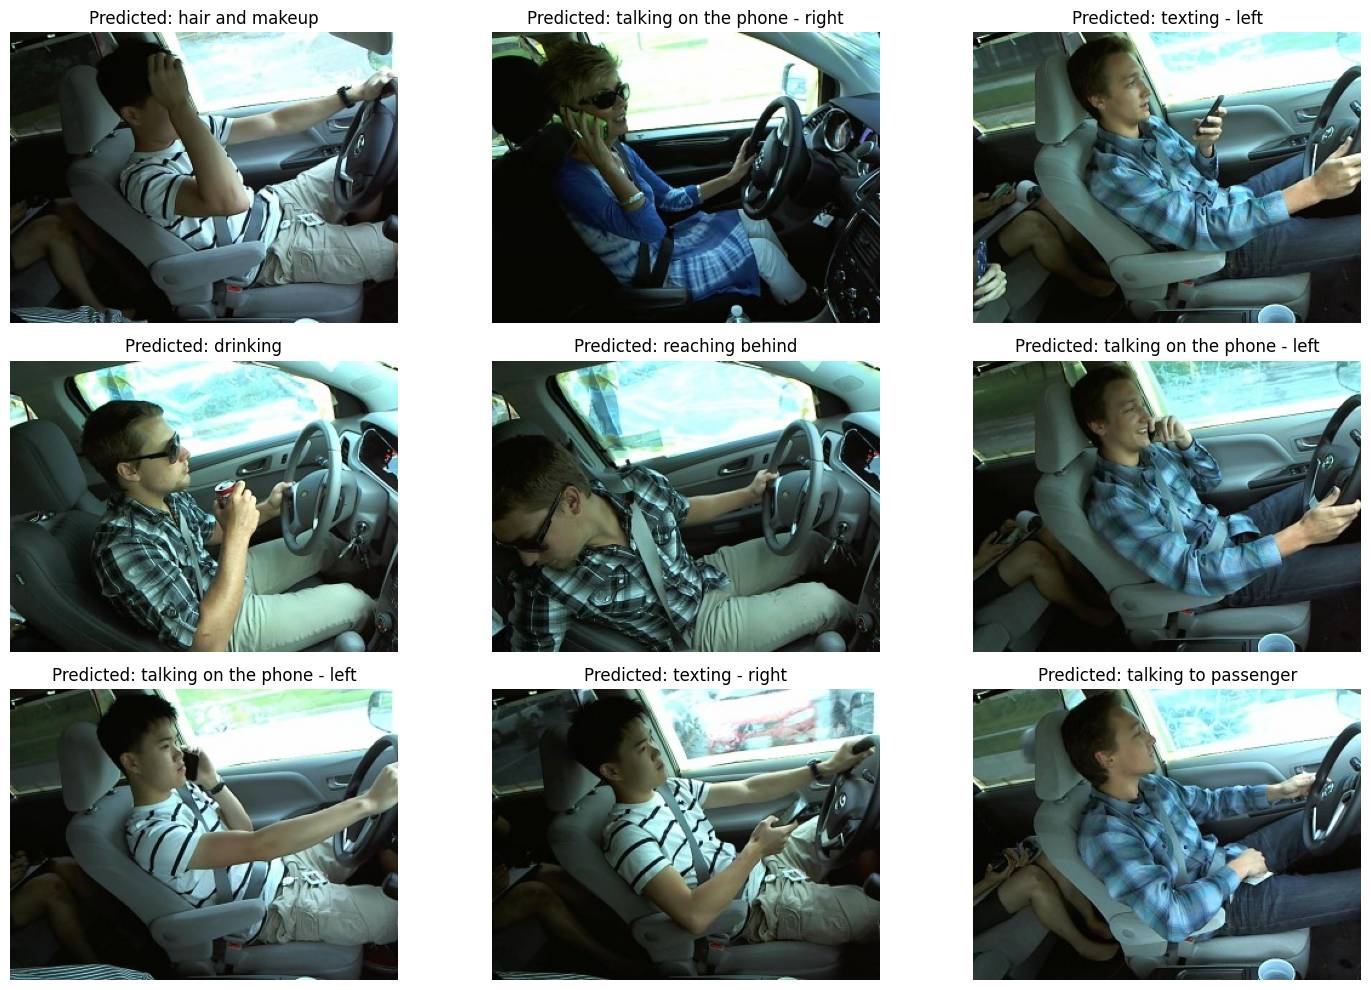

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms, models
import torch
import os

# Test path
test_dir = os.path.join(base_path, "imgs/test")
test_images = [f for f in os.listdir(test_dir) if f.endswith(".jpg")]

# Load model
model = models.resnet152(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 10)  # Adjust for 10 classes
model.load_state_dict(torch.load("resnet152_driver_distraction.pth"))
model.eval().to(device)

# Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

class_names = [
    'safe driving', 'texting - right', 'talking on the phone - right',
    'texting - left', 'talking on the phone - left', 'operating the radio',
    'drinking', 'reaching behind', 'hair and makeup', 'talking to passenger'
]

# Display predictions
plt.figure(figsize=(15, 10))
for i in range(9):
    img_path = os.path.join(test_dir, test_images[i])
    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)

    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    plt.title(f"Predicted: {class_names[predicted.item()]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
from torchvision import models
import torch.nn as nn

# Load ResNet152 model
model = models.resnet152(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 10)  # For 10 classes
model.load_state_dict(torch.load("resnet152_driver_distraction.pth"))
model = model.to(device)
model.eval()

# Collect true and predicted labels
true_labels = []
pred_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Plot Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix - ResNet152")
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Replace these with your actual ResNet-152 training logs
resnet152_train_losses = [125.764, 6.005, 3.158, 0.752]
resnet152_train_accuracies = [92.40, 99.68, 99.88, 99.98]
resnet152_val_accuracies = [99.55, 99.63, 99.72, 99.81]

epochs = range(1, len(resnet152_train_losses) + 1)  # [1,2,3,4]

plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, resnet152_train_losses, marker='o', color='blue', label='Training Loss')
plt.title('ResNet-152 Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, resnet152_train_accuracies, marker='o', label='Training Accuracy')
plt.plot(epochs, resnet152_val_accuracies, marker='s', label='Validation Accuracy')
plt.title('ResNet-152 Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
